In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ptitprince as pt # rainplot
import seaborn as sns
import math

In [46]:
all_users_folder = 'data/all_users/'

# Concatenate likelihoods

In [47]:
# Concatenate model info and nLLs

concat_mod_info = {}
mod_info_list = []
nLLs_concat = pd.DataFrame([])

for mod_name in range(0,14):
    # Folder path
    model_folder = all_users_folder + 'mod' + str(mod_name) + '/'
    # Load
    mod_info = pd.read_pickle(model_folder+'mod_parameters.pkl')
    data_mod = pd.read_pickle(model_folder+'mod_param_fits.pkl')
    # Temp nLL df
    n_params = len(mod_info['param_names'])
    nLLs = data_mod[['ID', 'nLL', 'Ntrials', 'Nparams']]
    nLLs.insert(1, 'model', mod_name)
    # Concat nLLs
    nLLs_concat = pd.concat([nLLs_concat, nLLs])
    # Concat mod infos
    mod_info_list.append(mod_info)

# Convert model info  
for k in mod_info.keys():
    concat_mod_info[k] = tuple(d[k] for d in mod_info_list)
df_mod_info = pd.DataFrame(concat_mod_info)

# Convert datatypes (=df.dtypes)
cols = nLLs_concat.columns.drop('ID')
nLLs_concat[cols] = nLLs_concat[cols].apply(pd.to_numeric)

# Compute BIC and AIC
# BIC = 2 * nLL + Nparams * ln(Ntrials)
# AIC = 2 * nLL + 2 * Nparams
#summary_stats = nLLs_concat.groupby('model').agg({'ID': 'count', 'Ntrials':'mean', 'Nparams':'mean', 'nLL':['mean', 'var']})
nLLs_concat['BIC'] = 2 * nLLs_concat['nLL'] + nLLs_concat['Nparams'] * np.log(nLLs_concat['Ntrials'])
nLLs_concat['AIC'] = 2 * nLLs_concat['nLL'] + 2 * nLLs_concat['Nparams']

# Save
nLLs_concat.to_pickle(all_users_folder+'nLLs_concat.pkl')

In [48]:
bic_aic_means = nLLs_concat.groupby('model').mean()
table_bic_aic = bic_aic_means.style.highlight_min(color = 'lightblue', subset = ['nLL', 'BIC', 'AIC'], axis = 0)
table_bic_aic.format({'Ntrials': "{:.0f}", 'Nparams': "{:.0f}"})
table_bic_aic

,nLL,Ntrials,Nparams,BIC,AIC
model,,,,,
0,53.559195,112,2,116.555388,111.118390
1,210.315381,112,3,434.786258,426.630762
2,44.979653,112,4,108.833301,97.959305
3,165.794124,112,4,350.462244,339.588248
4,210.293699,112,4,439.461393,428.587397
5,48.129994,112,3,110.415484,102.259987
6,40.817157,112,5,105.226808,91.634314
7,42.594091,112,5,108.780676,95.188182
8,43.112595,112,4,105.099186,94.225190


In [49]:
bic_aic_means = nLLs_concat.groupby('model').mean()
bic_aic_means_new = bic_aic_means.drop(index=[2,6,7,8,9,12,13]) # remove models with v0 and pi (not recoverable)
bic_aic_means_new = bic_aic_means_new.drop(index=[11]) # remove models with alpha_t and pi_t (not recoverable)
table_bic_aic_new = bic_aic_means_new.style.highlight_min(color = 'lightblue', subset = ['nLL', 'BIC', 'AIC'], axis = 0)
table_bic_aic_new.format({'Ntrials': "{:.0f}", 'Nparams': "{:.0f}"})
table_bic_aic_new

,nLL,Ntrials,Nparams,BIC,AIC
model,,,,,
0,53.559195,112,2,116.555388,111.118390
1,210.315381,112,3,434.786258,426.630762
3,165.794124,112,4,350.462244,339.588248
4,210.293699,112,4,439.461393,428.587397
5,48.129994,112,3,110.415484,102.259987
10,45.196982,112,4,109.267960,98.393965


# Compute best model per head

In [44]:
# for each ID find minimum AIC,BIC and index
min_vals = nLLs_concat.reset_index().groupby('ID')[['BIC', 'AIC']].agg(['idxmin', 'min']) 
# Initialise for concatenatio
win_mod_counts_df = pd.DataFrame([])
for criterion in ['BIC', 'AIC']:
    # get model number with index
    winning_mod_perID = nLLs_concat.iloc[min_vals[criterion]['idxmin']][['ID', 'model']]
    # Count occurences
    winning_mod_counts = winning_mod_perID[['model']].value_counts()
    # Concatenate AIC and BIC frames
    tmp = winning_mod_counts.to_frame(name=criterion)
    win_mod_counts_df = pd.concat([tmp, win_mod_counts_df], axis=1)
    
# Sort according to model number
win_mod_counts_df.sort_values(by=['model'], ascending=True, inplace=True)
win_mod_counts_df.reset_index(inplace=True)

# Save
win_mod_counts_df.to_pickle(all_users_folder+'win_mod_counts.pkl')

# Plots

In [27]:
# Load data
all_users_folder = 'data/all_users/'
nLLs_concat = pd.read_pickle(all_users_folder + 'nLLs_concat.pkl')
win_mod_counts_df = pd.read_pickle(all_users_folder + 'win_mod_counts.pkl')

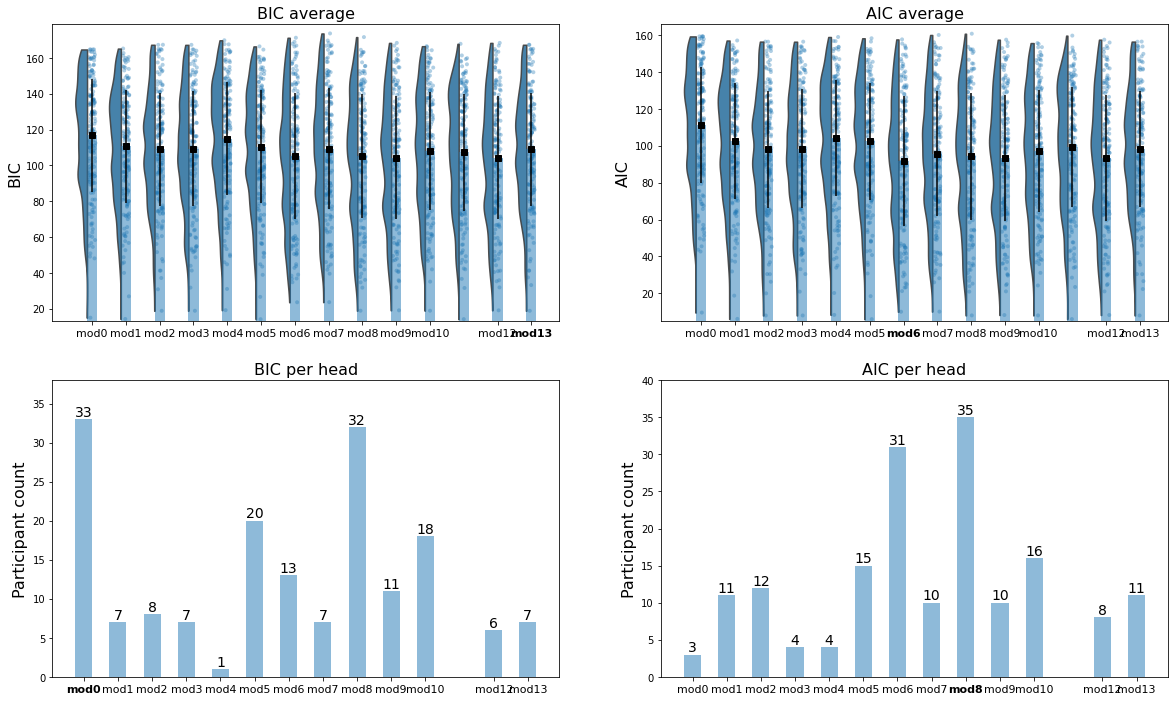

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(20,12), facecolor='white')

pal = sns.color_palette(n_colors=1)

mod_strings = ['mod' + str(mod_num) for mod_num in win_mod_counts_df['model']]
bic_aic_stats = nLLs_concat.groupby('model').agg({'BIC':['mean','std'], 'AIC':['mean','std']})

for ax, criterion in zip([axs[0][0], axs[0][1]], ['BIC', 'AIC']):
    pt.half_violinplot(ax = ax, x = 'model',  y = criterion, data = nLLs_concat, palette = pal, bw = .2, cut = 0., scale = "area", width = .7, inner = None, alpha=0.9)
    sns.stripplot(ax = ax, x = 'model',  y = criterion, data = nLLs_concat, palette = pal, edgecolor = "white", size = 4, jitter = 1, zorder = 0, alpha=.35)
    ax.bar(x = bic_aic_stats.index,  height = bic_aic_stats[criterion]['mean'], width=.3, color = pal, alpha=0.5);
    ax.errorbar(x = bic_aic_stats.index, y = bic_aic_stats[criterion]['mean'], yerr=bic_aic_stats[criterion]['std'], color='k', marker='s',linestyle='');

    ax.set_title(criterion + ' average', fontsize=16)
    ax.set_ylabel(criterion, fontsize=16)
    ax.set_xlabel('', fontsize=16)
    ax.set_ylim([nLLs_concat[criterion].min()-1, nLLs_concat[criterion].max()+5])
    #ax.set_ylim([nLLs_concat[criterion].min()-1, 180])
    ax.set_xticks(win_mod_counts_df['model'])
    ax.set_xticklabels(mod_strings, fontsize=11)
    
    # indicate winning model
    id_min = bic_aic_stats[criterion]['mean'].idxmin()
    ax.get_xticklabels()[id_min].set_weight('bold')
    
for ax, criterion in zip([axs[1][0], axs[1][1]], ['BIC', 'AIC']):
    
    bars = ax.bar(x = win_mod_counts_df['model'],  height = win_mod_counts_df[criterion], width=0.5, color = pal, alpha=0.5)
    ax.bar_label(bars, fontsize=14) # displays the values
    
    ax.set_title(criterion + ' per head', fontsize=16)
    ax.set_ylabel('Participant count', fontsize=16)
    #ax.set_ylim([0, math.ceil((win_mod_counts_df.values.max()+3)/10)*10])
    ax.set_ylim([0, win_mod_counts_df[criterion].max()+5])
    ax.set_xticks(win_mod_counts_df['model'])
    ax.set_xticklabels(mod_strings, fontsize=11)
    
    # indicate winning model
    ids_max = win_mod_counts_df[win_mod_counts_df[criterion]==win_mod_counts_df[criterion].max()].index.values
    for id_max in ids_max:
        ax.get_xticklabels()[id_max].set_weight('bold') 
        
plt.show()

In [29]:
# save all important matrice as pkls, load in Rstudio and plot
# Afficher aussi tableaux dans Rstudio

In [40]:
bic_aic_stats

BIC                    AIC           
             mean        std        mean        std
model                                              
0      125.651998  30.281108  120.215000  30.281108
1      118.877366  30.457025  110.721870  30.457025
2      119.398823  30.628360  108.524828  30.628360
3      120.466516  30.806102  109.592520  30.806102
4      124.519506  29.766175  113.645510  29.766175
5      117.665605  30.748600  109.510108  30.748600
6      117.419029  33.458271  103.826535  33.458271
7      121.766065  32.759242  108.173571  32.759242
8      114.470932  33.840253  103.596937  33.840253
9      115.745491  33.413057  104.871496  33.413057
10     117.885113  31.658257  107.011118  31.658257
11     116.412382  32.764376  108.256885  32.764376
12     115.813884  33.412368  104.939888  33.412368
13     119.814453  30.677774  108.940458  30.677774